## Predicción de series temporales en Python

Para explicar cómo podemos hacer predicción sobre series temporales, utilizaremos un famoso conjunto de datos sobre la evolución del número de pasajeros en una famosa aerolínea americana desde 1949 a 1960.

In [33]:

### import seaborn as sns
### import pandas as pd

import logging
import pickle
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
     plot_acf,
     plot_pacf
)
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error
# logger = logging.getLogger()
# logger.setLevel(logging.ERROR)


### Paso 1. Lectura del conjunto de datos

In [34]:
import seaborn as sns

df_raw = sns.load_dataset("flights")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [35]:
df_raw.sample(10,random_state=2025)

,year,month,passengers
2,1949,Mar,132
82,1955,Nov,237
77,1955,Jun,315
26,1951,Mar,178
23,1950,Dec,140
44,1952,Sep,209
54,1953,Jul,264
0,1949,Jan,112
5,1949,Jun,135
108,1958,Jan,340


El conjunto de datos en crudo nos serviría para realizar un proceso de Machine Learning usual como los que hemos visto en pasados módulos.  
En esta ocasión, necesitamos aplicar una transformación del mismo para generar una serie temporal con dos dimensiones: 
*   la temporal y 
*   la del dato que queremos analizar y predecir.  

En este caso,  
la dimensión temporal estará compuesta por
*   el mes (`month`) y 
*   el año (`year`) 
el dato que observaremos a lo largo del tiempo será 
* el número de pasajeros (`passengers`).

In [36]:
import pandas as pd

df_baking = df_raw.copy()
    # Crea una copia independiente del DataFrame original df_raw, llamada df_baking,
    # para trabajar con ella sin modificar el original.

df_baking['month'] = pd.to_datetime(df_baking['month'], format='%b').dt.month
print ("✔️Meses Transformados:\n", *df_baking['month'].unique())
    # Convierte el nombre del mes abreviado ("Jan", "Feb", etc.) en un número
    # (1 para enero, 2 para febrero, ..., 12 para diciembre).
    # El resultado se guarda en la misma columna "month" (sobrescribiéndola).

    # 📌 format='%b' le dice a pd.to_datetime que el mes está en formato abreviado.
    # 📌 .dt.month extrae el número de mes del objeto datetime.

df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1))
    # Crea una nueva columna "date" combinando "year" y "month", asignando el 
    # día 1 por defecto (porque no hay día en los datos).
    # Luego lo convierte a un objeto de fecha completo (datetime64).

    # 📌 pd.to_datetime(...).assign(day=1) crea una fecha como 2022-05-01 por ejemplo.

df_baking = df_baking.set_index('date')
print ("✔️Columna Date Creada como Index: \n", (df_baking.index).unique()) 
  
    # Convierte la columna "date" en el índice del DataFrame. Esto es muy común 
    # en análisis de series temporales, porque facilita operaciones como resampling,
    # plotting, etc.


df_baking = df_baking["passengers"].to_frame()
    # Selecciona solo la columna "passengers", conviertiendola en un DataFrame 
    # de una sola columna, y manteniendo el índice de fechas que se estableció 
    # en el paso anterior.
    # to_frame() convierte una Serie en un DataFrame, manteniendo el índice.


df = df_baking.copy()
print("✔️df_Sample:\n", df.sample(10,random_state=2025))


✔️Meses Transformados:
 1 2 3 4 5 6 7 8 9 10 11 12
✔️Columna Date Creada como Index: 
 DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)
✔️df_Sample:
             passengers
date                  
1949-03-01         132
1955-11-01         237
1955-06-01         315
1951-03-01         178
1950-12-01         140
1952-09-01         209
1953-07-01         264
1949-01-01         112
1949-06-01         135
1958-01-01         340


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB


### Machine Learning: 
Veremos la escencia del Modelo de Machine Learning para Series de Tiempo.

![alt text](image.png)


> **PARTICION DEL DATASET:** 
* **Sector Train (Pasado):**    
Para hacer forecasting Machine Learning, voy a obervar el compportamiento del pasado tomando el grupo de datos de entrenamiento (train), para luego predecir el futuro.  
* **Sector Test (Ultimo Periodo con Datos):**  
Tambien voy a necesitar el grupo de datos de prueba (test), que son datos ya conocidos, ubicados al final de mi serie temporal.  
Con ellos vere si estoy cumpliendo con la prediccion, y asi extrapolarla para predecir entonces el futuro. 
* **Sector Prediccion (Futuro)** 
El futuro vendria despues del test. 

> **CARACTERISTICAS DEL DATASET: (Verde)** 
* Tendencia (Positiva o Negativa)
* Sesonality (Curbas Periodicas)

> **RESIDUALES: (Naranja)**
Es la diferencia que hay entre mi prediccion y la realidad.
Si hago una prediccion de linea del tiempo, tratando de ajustarme lo mas posible a la linea de los datos reales, me encontrare con diferencias entre ambas curbas. Esas diferencias son los errores de prediccion que llamare residuales. 

#### **Step 1: EDA** Separo Datos

In [38]:
# CREAMOS EL DATASET DE PRUEBA Y ENTRENAMIENTO
# ---------------------------------------------------

# Los Ultimos 12 Meses los dejaremos como TEST, y el resto como TRAIN
# Para esto usaremos un sliceo de pandas, que nos permite seleccionar filas
# y columnas, donde 
# el primer ":" indica el rango de filas y 
# el segundo ":" indica el rango de columnas.
# df.iloc[filas, columnas]


df_train = df.iloc[:-12,:] # Selecciona todas las filas excepto las últimas 12 del DataFrame df.
print("✔️df_train Sample:\n", df_train.sample(10,random_state=2025))
    # :-12 significa "desde el inicio hasta 12 filas antes del final".
    # : después de la coma indica "todas las columnas".
    # Resultado: las primeras len(df) - 12 filas.

df_test = df.iloc[-12:,:] # Selecciona solo las últimas 12 filas del DataFrame df.
print("\n✔️df_test Sample:\n", df_test.sample(10,random_state=2025))
    # -12: significa "desde la fila número 12 desde el final hasta el final".
    # : indica todas las columnas.
    # Resultado: las últimas 12 filas



✔️df_train Sample:
             passengers
date                  
1953-01-01         196
1950-08-01         170
1954-04-01         227
1954-07-01         302
1958-06-01         435
1952-02-01         180
1959-10-01         407
1951-06-01         178
1953-11-01         180
1949-03-01         132

✔️df_test Sample:
             passengers
date                  
1960-11-01         390
1960-06-01         535
1960-02-01         391
1960-08-01         606
1960-12-01         432
1960-07-01         622
1960-01-01         417
1960-05-01         472
1960-10-01         461
1960-04-01         461


#### **Step 1: EDA** Analisis Estadistico

In [39]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,132.0,262.5,106.6,104.0,176.5,239.5,343.2,559.0


In [40]:
# Tenemos 132 Observaciones, ya que reducimos el dataset sacandole 12 meses para el test.
# La media de pasajeros es 262, con un mínimo de 104 y un máximo de 559.
# La desviación estándar es 106, lo que indica que hay una gran variabilidad en el número de pasajeros.
# La mediana esta en 239, lo que indica que la mitad de los meses tienen menos de 239 pasajeros y la otra mitad más.
# La mediana esta bastante cerca de la media, lo que indica que la distribución es bastante simétrica.
# Veremos una distribucion que tiene cierta desviacion

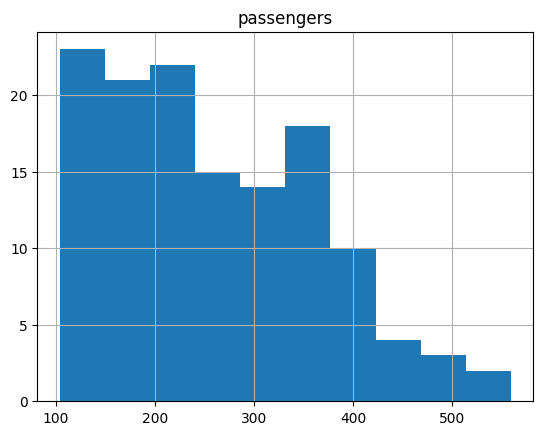

In [41]:
# HISTOGRAMA
df_train.hist()
plt.show()

In [42]:
# Los datos mas representativos, los que vemos con mas frecuencia, estan entre 100 y 200
# y los que menos frecuencia tienen van del 300 hacia adelante.
# Veremos seguramente algo distinto a lo que venimos acostumbrados, en la distribucion de los datos, 
# que en general es la forma de una campana. 
# Lo mas probable es que tenga tendencia.
# Para averiguarlo vamos a graficar la serie temporal.



#### **Step 1: EDA** Analisis Visual de la Serie Temporal

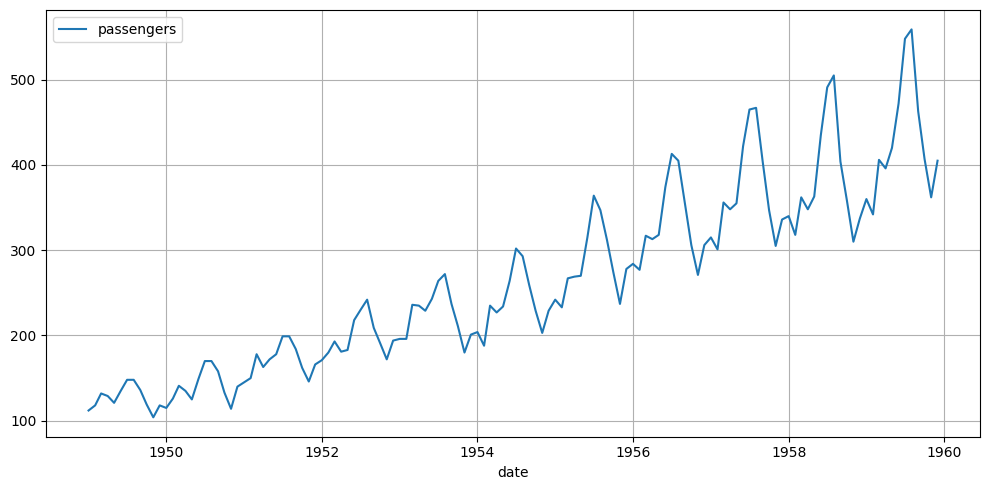

In [43]:
# GRAFICAMOS LA SERIE TEMPORAL para llevar a cabo un análisis visual de la misma

import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(df_train)
plt.grid(True)
plt.tight_layout()
plt.show()

### Paso 2. Análisis de una serie temporal

Para analizar una serie temporal, como vimos en la teoría, debemos estudiar varios parámetros:

- **Tendencia**: Se aprecia una tendencia ascendente, lo que indica que el número de pasajeros ha aumentado a lo largo del tiempo. Esto puede deberse a varios factores: crecimiento de la industria aeronáutica y dotación de más recursos para movilizar pasajeros, reducción de precios, un mayor interés por los viajes aéreos, etcétera.
- **Estacionalidad**: Se observa cierta estacionalidad en los datos, con ciertos meses que consistentemente tienen más vuelos que otros. Esto podría deberse a la demanda estacional (más personas volando durante las vacaciones, por ejemplo).
- **Variabilidad**: Se observan ciertos puntos de variabilidad en la serie temporal, sobre todo entre los periodos de aumento y disminución en la demanda.
- **Puntos atípicos** (*Outliers*): Estudiando la tendencia y la estacionalidad de la serie temporal, no se aprecian outliers en la serie temporal.
- **Puntos de inflexión**: Dependiendo del año, el aumento en el número de pasajeros no es regular y a veces se producen variaciones en la pendiente; estos son, puntos de inflexión.

A través de un análisis visual podríamos ser capaces de estimar estas métricas a ojo, pero siempre es mejor orientar el análisis a los datos matemáticos. Para la labor de realizar predicciones sobre series temporales y analizarlas, nos apoyaremos en la librería `statsmodels`:

#### Descomposición de la serie

La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función `seasonal_decompose` de la biblioteca `statsmodels` para descomponer la serie de tiempo en sus **componentes**:
* Tendencia: Tendencia muestra la dirección general de la serie a lo largo del tiempo.
* Estacionalidad: Muestra patrones que se repiten en intervalos regulares (en este caso, cada 12 meses).
* Residuos: Muestra la variación que no se puede explicar por la tendencia o la estacionalidad.


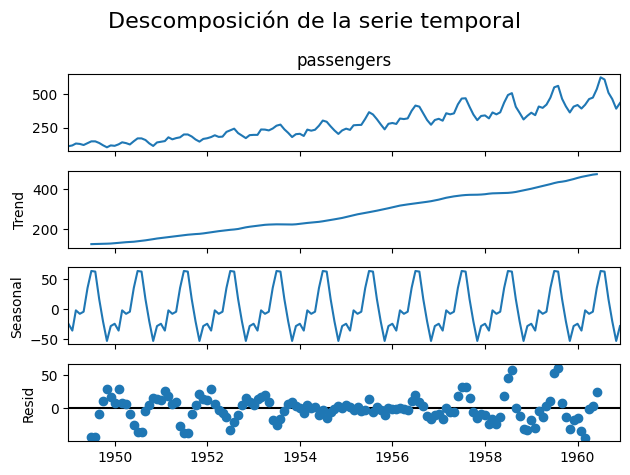

In [44]:
# Descomponemos la serie temporal en sus componentes: TENDENCIA, ESTACIONALIDAD y RESIDUO.
# ------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['passengers'],period=12)

    # ¿Qué hace seasonal_decompose?
    # Descompone la serie en:
    #     ▶ decomposition.trend → Tendencia a lo largo del tiempo.  
    #     ▶ decomposition.seasonal → Componente estacional repetitivo (cíclico). 
    #     ▶ decomposition.resid → Residuos (lo que no es tendencia ni estacionalidad). 
    #     ▶ decomposition.observed → La serie original


# Graficamos la descomposición
# ------------------------------------------------------------------------------------------------
decomposition.plot()
    # Graficamos la descomposición
    # figsize=(12, 8) establece el tamaño del gráfico.
    # legend=False oculta la leyenda de la gráfica.
    # plt.show() muestra el gráfico.
plt.suptitle('Descomposición de la serie temporal', fontsize=16)
plt.tight_layout()
plt.show()
# La serie tiene una tendencia creciente, lo que indica que el número de pasajeros ha aumentado con el tiempo.
# La estacionalidad muestra picos en ciertos meses, lo que indica que hay un patrón cíclico en los datos.
# La estacionalidad parece ser anual, ya que los picos se repiten cada 12 meses.

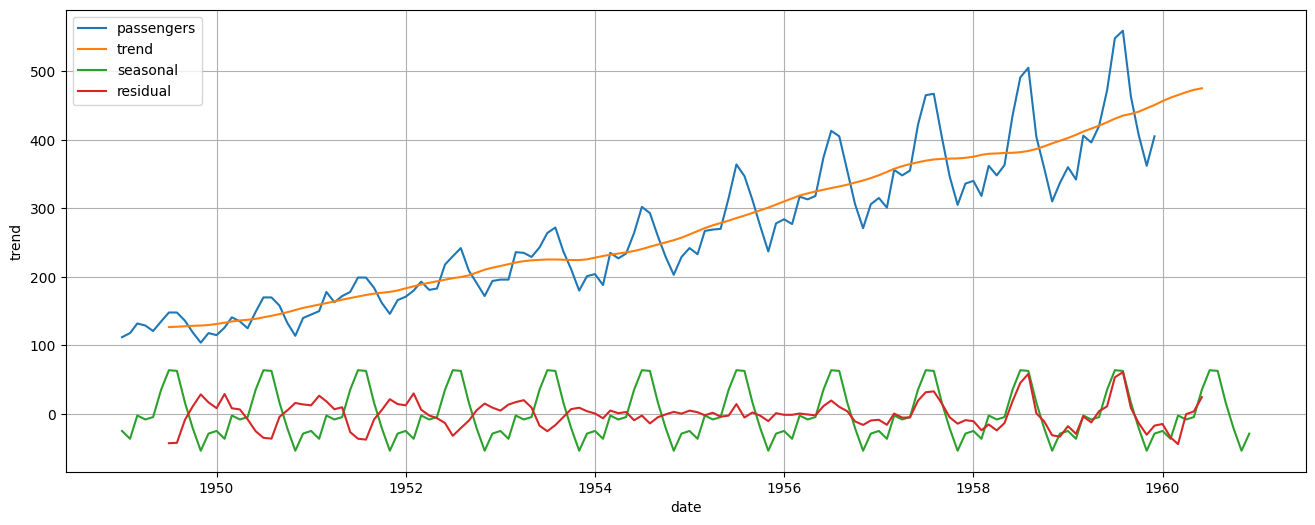

In [45]:
# Graficamos todos los componentes de la serie temporal en un mismo grafico
# ------------------------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(df_train)
sns.lineplot(trend,label='trend')
sns.lineplot(seasonal,label='seasonal')
sns.lineplot(residual,label='residual')
plt.grid(True)
plt.show()

# Cada punto del azul (df_train) es la suma de los puntos de las otras tres series.
# La serie azul (df_train) es la suma de las tres series: tendencia (naranja), estacionalidad (verde) y residuo (rojo).

#### **Análisis de la tendencia**

La tendencia se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos al componente `trend` del resultado `decomposition`.

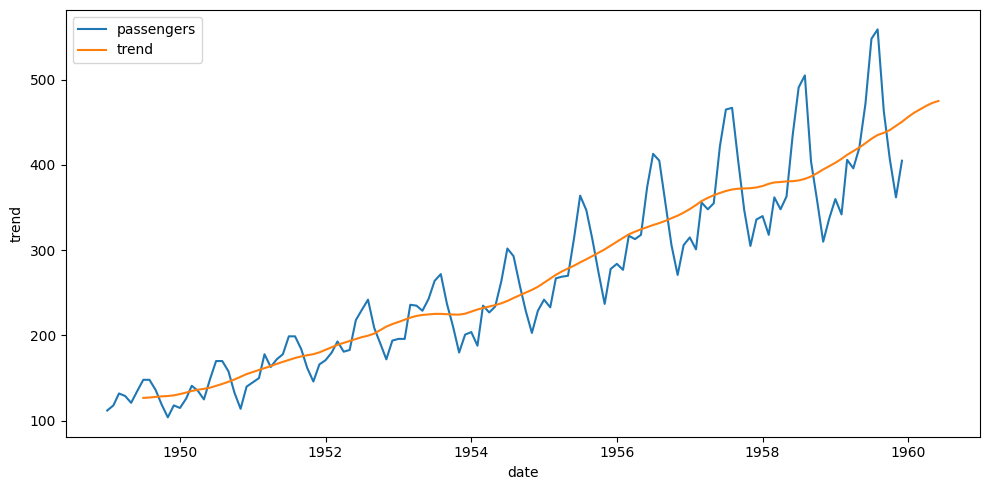

In [46]:
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_train)
sns.lineplot(data = trend, label='trend')

plt.tight_layout()
plt.show()

Se confirma lo observado: una clara tendencia positiva a lo largo de los años.
Esto puede deberse a varios factores: 
 * crecimiento de la industria aeronáutica y 
 * dotación de más recursos para movilizar pasajeros, 
 * reducción de precios, 
 * un mayor interés por los viajes aéreos, 
 * etcétera.

In [47]:
# SOLUCION DE LA PLATAFORMA.


from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df_train)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  0.9
p-value                         1.0
#Lags Used                     13.0
Number of Observations Used   118.0
Critical Value (1%)            -3.5
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64

#### **Análisis de la estacionalidad**

La estacionalidad se refiere a los patrones repetitivos en los datos. Para acceder a su información recurrimos al componente `seasonal` del resultado `decomposition`. Pero antes aplicaremos la lupa para entender en que meses se dan los picos.

---
#####  Profesor:


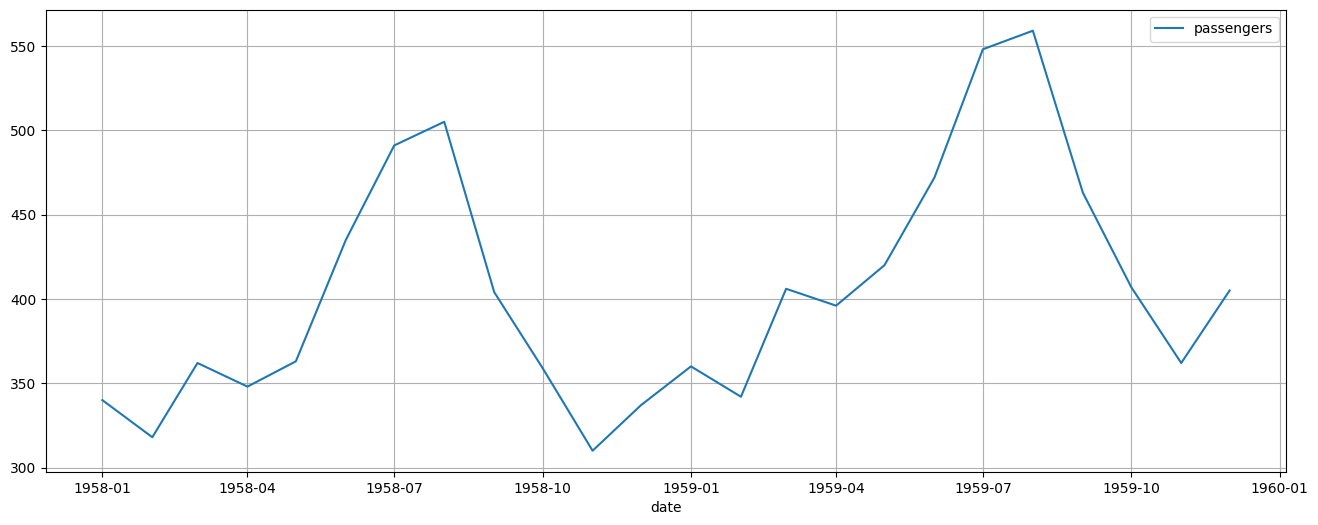

In [65]:
# Aplicaremos la lupa para determinar en que mes es que se generan los picos
fig, axis = plt.subplots(figsize = (16, 6))
sns.lineplot(df_train.iloc[-24:,:])
plt.grid(True)
plt.show()

Vemos que los picos en general se producen en agosto, (vacaciones en EEUU), lo cual tiene sentido ya que son vuelos domesticos en estados unidos.


#####  Profesor
---

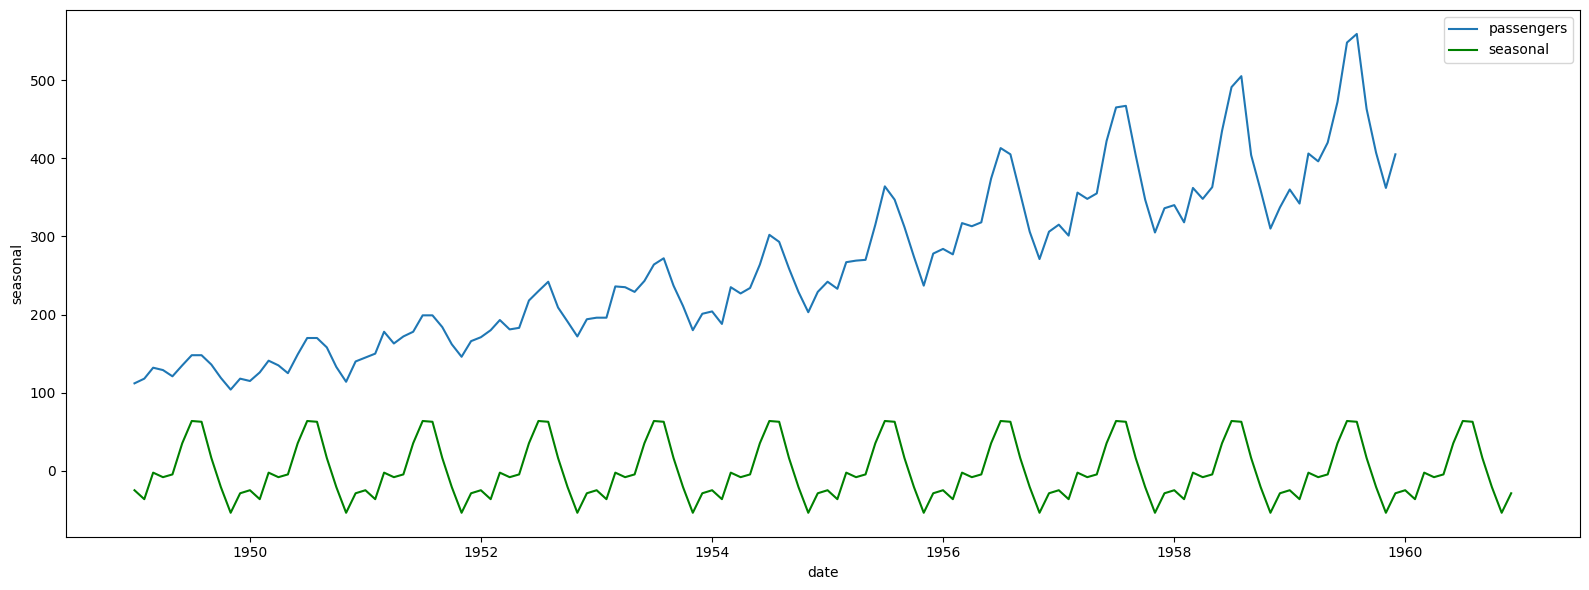

In [49]:
# Graficamos la estacionalidad
# ------------------------------------------------------------------------------------------------

fig, axis = plt.subplots(figsize = (16, 6))

sns.lineplot(data = df_train)
sns.lineplot(data = seasonal, label='seasonal', color = 'green')

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada **Prueba de Dickey-Fuller** (*Dickey-Fuller test*), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria:

In [67]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df_train)


Resultados de la prueba de Dickey-Fuller:


Test Statistic                  0.9
p-value                         1.0
#Lags Used                     13.0
Number of Observations Used   118.0
Critical Value (1%)            -3.5
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64

Aquí podemos ver que el `p-value` es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

---
#####  Profesor:


Si una serie es estacionaria, quiere decir que no tiene tendencia.  
Aislar el efecto de la tendencia en nuestra serie, para ver si la estacionalidad se mantiene o no.   
Una forma muy visual de verlo es aplicandole la primer y segunda derivada a mi serie.

![alt text](image-1.png)

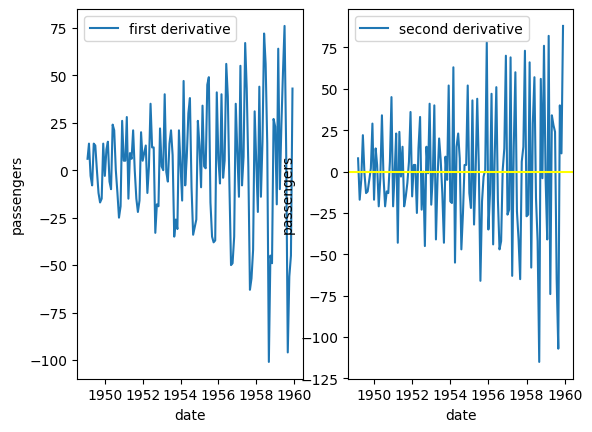

In [50]:
# LE SACAREMOS LA TENDENCIA A LA SERIE, APLICANDOLE LA PRIMERA Y SEGUNDA DERIVADA
# ---------------------------------------------------------------------------------
# La primera derivada es la diferencia entre cada punto y el anterior.
# La segunda derivada es la diferencia entre cada punto y el anterior de la primera derivada.

fig,ax=plt.subplots(1,2)
sns.lineplot(df_train['passengers'].diff(),label='first derivative',ax=ax[0]) # Aca le estoy diciendo que me haga la primera derivada para sacarle la tendencia
sns.lineplot(df_train['passengers'].diff().diff(),label='second derivative',ax=ax[1], ) # Aca le estoy diciendo que me haga la segunda derivada para sacarle aun mas la tendencia
plt.axhline(0,color='yellow')
plt.show()

Se observa claramente, que la segunda derivada es mas estable que la primera.

Lo que nos muestra que aplicando la segunda derivada ya casi obtenermos la serie sin el efecto de la tendencia. La media ronda en cero (yellow line).  
En el grafico de la primer derivada hay mas castigo hacia abajo, los valores no estan tan alrededor del cero. Esto habla de una leve tendencia presente.

Tambien podemos evaluar la estacionalidad desde el punto de vista estadistico, aplicando la prueba ADF.

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada **Prueba de Dickey-Fuller** (*Dickey-Fuller test*), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria:  
* dado un alpha = 0.05 
* if the p value is above alpha then we can say that it is not stationary (it has trend)
* if p value < alpha then we can rule out that it is stationary  (it has no trend)

In [51]:
from statsmodels.tsa.stattools import adfuller
# La prueba de Dickey-Fuller aumentada (ADF) es una prueba estadística que se utiliza para determinar si una serie temporal es estacionaria o no.
# La hipótesis nula (H0) es que la serie temporal tiene una raíz unitaria, lo que significa que no es estacionaria.
# La hipótesis alternativa (H1) es que la serie temporal no tiene una raíz unitaria, lo que significa que es estacionaria.
# Si el valor p es menor que un nivel de significancia (por ejemplo, 0.05), se rechaza la hipótesis nula y se concluye que la serie temporal es estacionaria.
# Si el valor p es mayor que el nivel de significancia, no se puede rechazar la hipótesis nula y se concluye que la serie temporal no es estacionaria.


ad_fuller = adfuller(df_train)  # aplica el test ADF a tu serie (df_train).
print(f'adf statistic: {ad_fuller[0]:.2f}') # ad_fuller[0] → el estadístico ADF
print(f'adf P Value: {ad_fuller[1]:.2f}') # ad_fuller[1] → el valor-p (p-value)

print("Si el p-value < 0.05, entonces podés concluir que la serie es estacionaria.")

adf statistic: 0.89
adf P Value: 0.99
Si el p-value < 0.05, entonces podés concluir que la serie es estacionaria.


Aquí podemos ver que el `p-value` es mayor a 0.05, esto significa que tomaremos esta serie como no estacionaria. 
Como la evidencia de que tiene tendencia es enorme, es que vemos que el p-value es tan grande. 

In [52]:
# AHORA LE APLICAREMOS LA PRIMER DERIVADA A LA SERIE, PARA VER SI SE HACE MAS ESTACIONARIA, Y LO EVALUAREMOS CON EL P-VALUE.
# --------------------------------------------------------------------------------

ad_fuller = adfuller(df_train['passengers'].diff().dropna())

# Con diff() aplicamos la derivada primera a la serie temporal, lo que nos ayuda a eliminar la tendencia.  
# diff() calcula la diferencia entre cada punto y el anterior, eliminando el primer valor NaN que se genera.  
# dropna() elimina los valores NaN que se generan al calcular la diferencia.
# adfuller(df_train['passengers'].diff().dropna())  # aplica el test ADF a la nueva serie

print(f'adf statistic: {ad_fuller[0]:.2f}') # ad_fuller[0] → el estadístico ADF
print(f'adf P Value: {ad_fuller[1]:.2f}') # ad_fuller[1] → el valor-p (p-value)

print("Si el p-value < 0.05, entonces podés concluir que la serie es estacionaria.")

adf statistic: -2.40
adf P Value: 0.14
Si el p-value < 0.05, entonces podés concluir que la serie es estacionaria.


Tal como lo habiamos notado en el grafico de la primer derivada, aun se observa una leve tendencia, perO es muy chica, por eso el p-value es tan pequeño.

In [53]:
# AHORA LE CALCULAREMOS LA DERIVADA SEGUNDA DE LA SERIE, PARA VER SI SE HACE AUN MAS ESTACIONARIA, Y LO EVALUAREMOS CON EL P-VALUE.
# --------------------------------------------------------------------------------

# Agregando un diff() adicional calculamos la segunda derivada

ad_fuller = adfuller(df_train['passengers'].diff().diff().dropna())

print(f'adf statistic: {ad_fuller[0]:.2f}') # ad_fuller[0] → el estadístico ADF
print(f'adf P Value: {ad_fuller[1]:.2f}') # ad_fuller[1] → el valor-p (p-value)
print("Si el p-value < 0.05, entonces podés concluir que la serie es estacionaria.")

adf statistic: -14.25
adf P Value: 0.00
Si el p-value < 0.05, entonces podés concluir que la serie es estacionaria.


Tal como lo vimos en el grafico de la segunda derivada, se elimino la tendencia de la serie. Por esto el p-value es 0.
Esto genera una nueva serie sin el efecto de la tendencia, ya dejo de ser estacionaria. 

Con esto logramos calcular el valor d. Creo que es el adf static = -14.25.

Una vez definido d, tenemos que calcular el valor p.    
El valor p se calcula con la correlacion parcial.   
Lo que calcula es el temrino autoregresivo.   
Y autoregresivo ace referencia a seasonality, ya que se refiere a que yo estoy relacionado con el de atras y el de adelante.

Si existe seasonality, mis vecinos cercanos van a estar relacionados conmigo, pero no lo aran los vecinos que esten mas lejos. Capturando asi el grado de seasonality.  
![alt text](image-3.png)

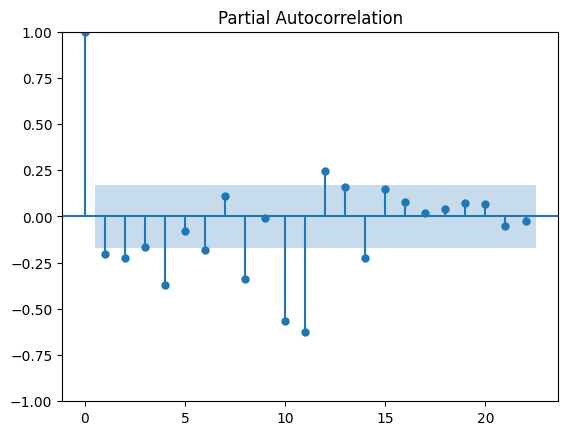

In [54]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_train.diff().diff().dropna())
plt.show()

El termino p es la cantidad de puntos que caen fuera de la banda celeste.  
Contamos los puntos hasta el primero que cae en la banda celeste. El tercero ya cayo adentro.
Quiere decir que p podria ser 1 o 2.
Lo que estamos viendo es como se relaciona cada punto con el punto anterior, y con el que esta antes del anterior.
La banda celeste es que tan certero es que esto es asi. Si estoy afuera, es que es correcto, y si estoy adentro es que no es probable, puede haber sido azar.

Para todos los puntos la correlacion con el mismo siempre es 1. Por eso el primer punto siempre esta ubicado en 1.

Ahora nos toca calcular el termino q que es el moving average.

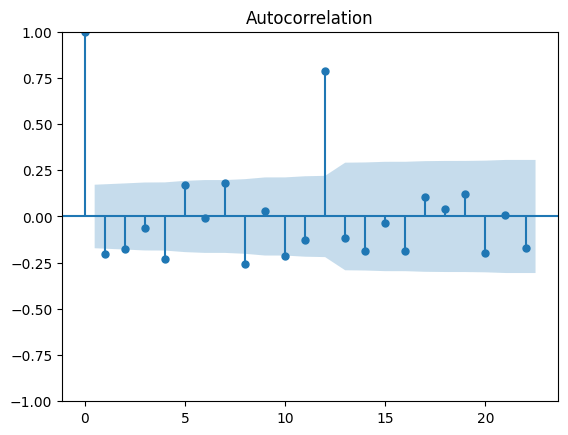

In [55]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_train.diff().diff().dropna())
plt.show()

Aca vemos que dentro de la banda celeste hay un punto, y el segundo puede que si como que no.
por lo tanto q es 1.

Ya tenemos entonces los tres valores **(d,p,q)**  
* d = 2, (2 derivadas)  
* p = 2 o 1 (por la autocorrelacion parcial)  
* q = 1 (por el moving average)  

Con lo cual tenemos dos opciones posibles para nuestro modelo  
* (2,2,1)
* (2,1,1)

Con esto ya podemos instanciar nuestro modelo

In [56]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(df['passengers'],order=(2,1,1)) 
# order variables 'd' (differencing),'p' (partial autocorrelation), 'q' (moving average) 
# the goal in setting these is to make the P>|z| to be the lowest possible. 
# find the lowest AIC or P>|z| for highest precision
ts_arima = arima.fit()
print(ts_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Tue, 22 Apr 2025   AIC                           1378.338
Time:                        11:45:15   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Debemos concentrarnos en este sector
![alt text](image-4.png)

Y lo que nos dice es, este modelo estara bien cuando:
para las filas ar.L1, ar.L2 y ma.L1, el valor de la columna "P>|z|" sea lo mas chiquito posible. 



# El modelo usado para una serie de tiempo es ARIMA, y se calcula con tres parametros: (d,p,q)
# lo que vimos hasta ahora son las herramientas para calcular esos parametros.

Ahora lo que nos queda es predecir. 
Para esto vamos con y_hat.

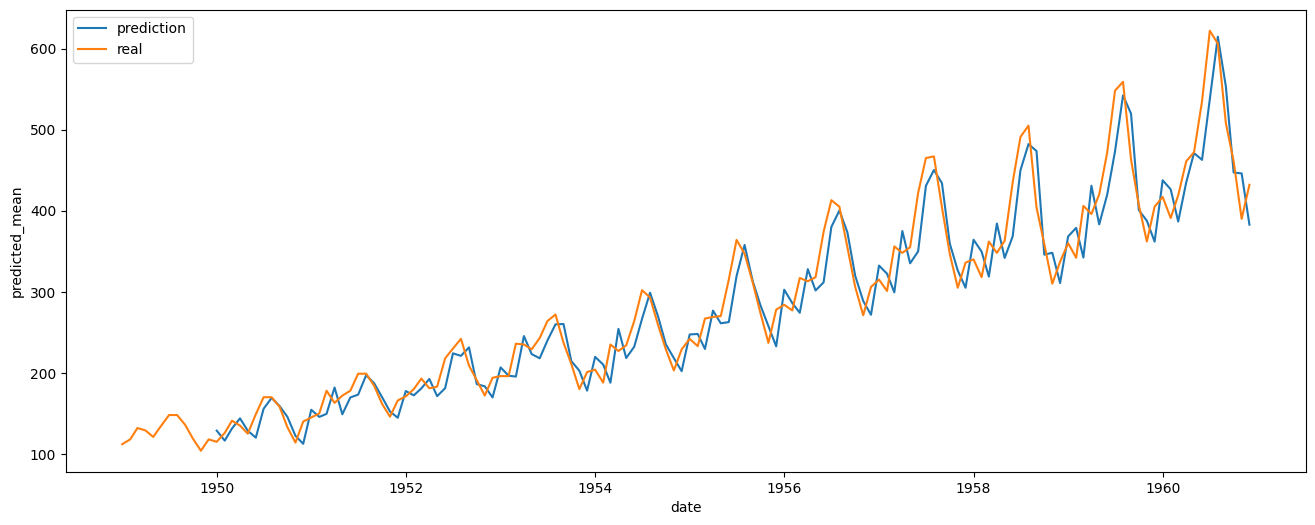

In [57]:
y_hat = ts_arima.predict(12) # argument 1, how many points into the future do you want to predict?

plt.figure(figsize=(16, 6))
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['passengers'],label='real')
plt.show()

Recordar que estamos trabajando con el dataset de train (o sea, no contienen los ultimos 12 meses)

![alt text](image-2.png)

# ACA

#### **Análisis de la variabilidad**

La variabilidad implica el estudio de los residuos: que es cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos al componente `resid` del resultado `decomposition`.

Se observan ciertos puntos de variabilidad en la serie temporal, sobre todo entre los periodos de aumento y disminución en la demanda.

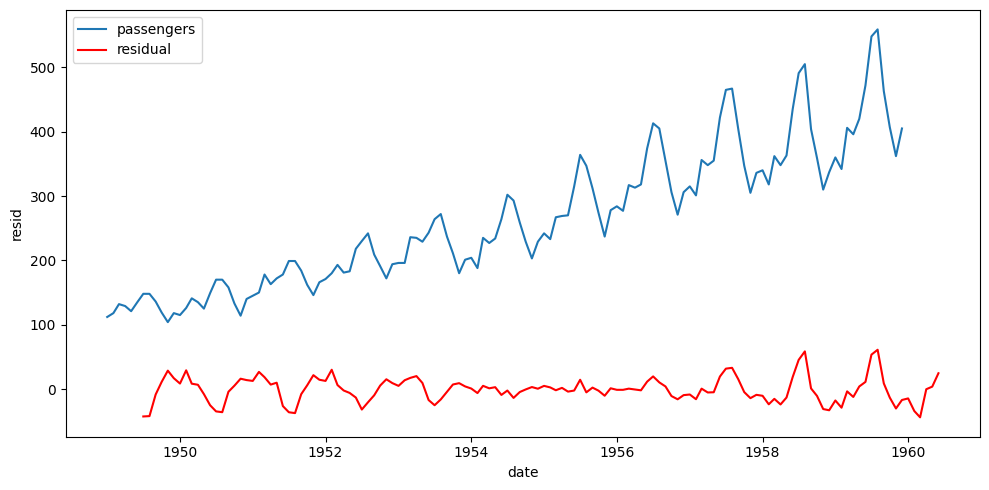

In [58]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df_train)
sns.lineplot(data = residual, color='red', label='residual')

plt.tight_layout()

plt.show()

Se confirma en parte lo observado, ya que la carga de residuos se hace más notable al inicio y al final del periodo estudiado.

#### **Análisis de la autocorrelación**

 La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

 

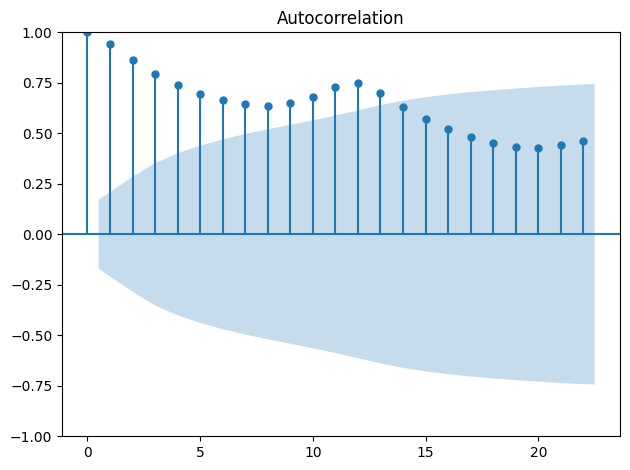

In [59]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_train)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye a lo largo del tiempo.

### Paso 3: Entrenamiento del modelo

Un modelo $ARIMA(p, d, q)$ consta de tres hiperparámetros:

- `p`: El orden del componente autorregresivo (AR).
- `d`: El grado de diferenciación necesario para hacer la serie de tiempo estacionaria.
- `q`: El orden del componente de media móvil (MA).

El estudio de estos hiperparámetros escapa nuestra función, ya que es un análisis puramente matemático-estadístico. Hoy en día existen herramientas que nos facilitan la vida estimando de forma interna los hiperparámetros más apropiados y generando el mejor modelo posible, como el paquete `pmdarima` y su función `auto_arima`. Lo único que tenemos que considerar es que para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla:

In [60]:
ts_stationary = df_train.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                 -2.4
p-value                         0.1
#Lags Used                     13.0
Number of Observations Used   117.0
Critical Value (1%)            -3.5
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64

Ahora la serie si que lo es, y podemos aplicar el método ARIMA automático:

In [61]:
from pmdarima import auto_arima

#¿Qué es pmdarima?
# pmdarima (también conocido como auto_arima) es una librería que automatiza el ajuste de modelos 
# ARIMA y SARIMA para series de tiempo, muy útil para encontrar los mejores hiperparámetros 
# sin probar manualmente.

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=906.758, Time=0.02 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=902.411, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=903.283, Time=0.20 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[12]             : AIC=905.065, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.11 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=902.632, Time=0.40 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=902.930, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=902.557, Time=0.09 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=902.217, Time=0.09 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=904.555, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=899.902, Time=0.03 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12]             : AIC=900.823, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=901.053, Time=0.09 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(2,0,0)(0,1,0)[12]             : AIC=901.338, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=900.972, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=900.685, Time=0.03 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,0)[12]             : AIC=902.967, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12]          
Total fit time: 4.675 seconds


Como podemos ver, la función hace una búsqueda en el espacio de soluciones posible para estimar los mejores parámetros. En este caso tendríamos un $ARIMA(0, 0, 1)$. El modelo que devuelve esta función es totalmente usable, como cualquier otro que hayamos visto, y su función `summary()` devuelve información estadística y sobre su rendimiento que tiene gran valor:

In [62]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  131
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.951
Date:                            Tue, 22 Apr 2025   AIC                            899.902
Time:                                    11:45:21   BIC                            905.460
Sample:                                02-01-1949   HQIC                           902.159
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2431      0.090     -2.697      0.007      -0.420      -0.066
sigma2       108.8757     13.306      8.183      0.000      82.797     134.954
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.89   Prob(JB):                         0.75
Heteroskedasticity (H):               1.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Paso 3: Predicción del modelo

Una vez se ha entrenado el modelo, se puede utilizar para predecir a futuro (predeciremos los siguientes `10` meses)

In [63]:
forecast = model.predict(10)
forecast

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1960-01-01    19.1
1960-02-01   -17.1
1960-03-01    63.8
1960-04-01    -9.9
1960-05-01    24.0
1960-06-01    52.0
1960-07-01    76.0
1960-08-01    11.0
1960-09-01   -96.0
1960-10-01   -56.0
Freq: MS, dtype: float64

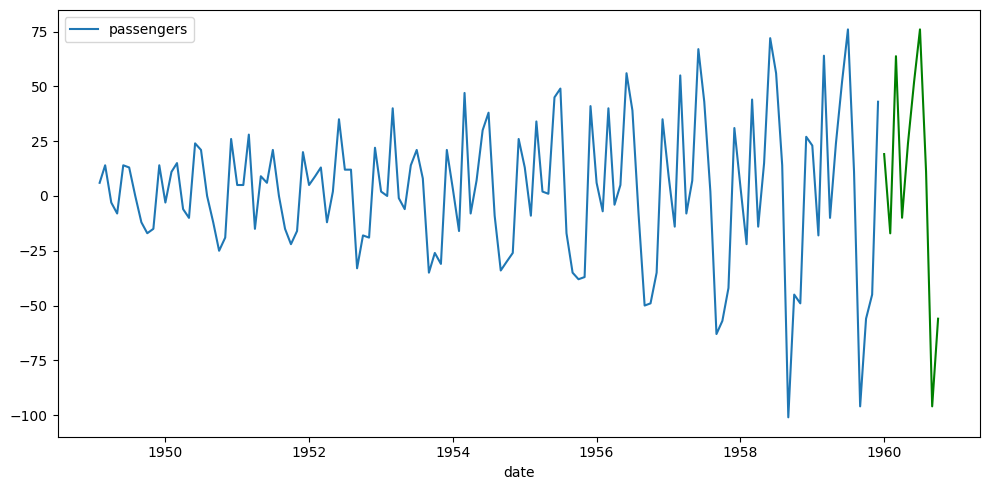

In [64]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

Ahora nuestro modelo es capaz de realizar predicciones a futuro sobre nuestra serie estacionaria.